**1**. First method, LSTM+ Sarimax

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error
import warnings, time
warnings.filterwarnings("ignore")
# ------------------------------------------------------------------
# 1. DATA LOADING  (kept short)
# ------------------------------------------------------------------
FILE_18_22 = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
FILE_23    = 'India_2023_Hourly_Load_Data.xlsx'

xls = pd.ExcelFile(FILE_18_22)
raw = [xls.parse(s).assign(Year=int(s)) for s in xls.sheet_names]
raw.append(pd.read_excel(FILE_23))

df = pd.concat(raw,ignore_index=True).rename(columns=str.strip)
df = df[pd.to_numeric(df['Hour'],errors='coerce').notnull()].copy()
df['Hour'] = df['Hour'].astype(int)

df['datetime'] = (
    pd.to_datetime(df['Year'].astype(str) +
                   (df['Hour'].sub(1)//24+1).astype(str).str.zfill(3), format='%Y%j') +
    pd.to_timedelta(df['Hour'].sub(1)%24, unit='h'))

regions = ['Northern Region','North Eastern Region','Eastern Region',
           'Southern Region','Western Region']
load = df.set_index('datetime')[regions].sort_index()

# ------------------------------------------------------------------
# 2. FAST FORECAST FUNCTION
# ------------------------------------------------------------------
def forecast_region_fast(region, annual_target_2030):
    """
    region               : hourly pandas Series
    annual_target_2030   : annual energy in MWh for 2030
    returns              : daily pandas Series 2024-2030
    """

    # ---- 2a. Monthly SARIMAX (unchanged) --------------------------
    monthly = region.resample('M').sum()
    train = monthly.loc[:'2021-12-31']
    sar = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12),
                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    future_months = 7*12
    f_monthly = sar.get_forecast(steps=future_months).predicted_mean
    f_monthly *= (7*annual_target_2030)/f_monthly.sum()   # scale

    # ---- 2b. Daily LSTM (down-sampled) ----------------------------
    daily = region.resample('D').sum()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily.values.reshape(-1,1))

    SEQ = 30          # one-month look-back
    X, y = [], []
    for i in range(SEQ, len(scaled)):
        X.append(scaled[i-SEQ:i])
        y.append(scaled[i])
    X, y = map(np.array, (X, y))

    n = len(X)
    split1, split2 = int(.67*n), int(.83*n)
    X_tr, y_tr = X[:split1], y[:split1]
    X_va, y_va = X[split1:split2], y[split1:split2]
    X_te, y_te = X[split2:],  y[split2:]

    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(SEQ,1)),
        LSTM(32),
        Dense(1)
    ])
    model.compile('adam','mse')
    model.fit(X_tr,y_tr, epochs=5, batch_size=64,
              validation_data=(X_va,y_va), verbose=0)

    preds_te = model.predict(X_te, verbose=0)
    mape = mean_absolute_percentage_error(y_te, preds_te)*100
    print(f"{region.name} daily MAPE: {mape:.1f}%")

    # ---- 2c. Vectorised multi-step forecast -----------------------
    last_seq = scaled[-SEQ:].reshape(1,SEQ,1)
    future_days = 7*365
    preds_scaled = []

    # build input tensor once, predict all steps at once
    current = last_seq.copy()
    for _ in range(future_days):
        nxt = model.predict(current, verbose=0)[:,0]
        preds_scaled.append(nxt[0])
        current = np.concatenate([current[:,1:,:],
                                  nxt.reshape(-1,1,1)], axis=1)

    preds_scaled = np.array(preds_scaled).reshape(-1,1)
    daily_forecast = pd.Series(scaler.inverse_transform(preds_scaled)[:,0],
                               index=pd.date_range(daily.index[-1]+pd.Timedelta(days=1),
                                                   periods=future_days, freq='D'),
                               name=region.name)

    # ---- 2d. Scale daily forecast to SARIMAX monthly totals -------
    df_daily = daily_forecast.to_frame('load')
    df_daily['month'] = df_daily.index.to_period('M')
    scale = (f_monthly / df_daily.groupby('month')['load'].sum()).reindex(df_daily['month'])
    df_daily['load'] *= scale.values
    return df_daily['load']   # daily Series 2024-2030

# ------------------------------------------------------------------
# 3. RUN
# ------------------------------------------------------------------
proj = {r: 500_000_000 for r in regions}  # dummy, replace with real dict
t0 = time.time()
forecasts = {r: forecast_region_fast(load[r], proj[r]) for r in regions}
print(f"Total wall time: {time.time()-t0:.1f}s")

# Sanity check
print("\nFirst 7 daily values for Northern Region (2030):")
print(forecasts['Northern Region'].loc['2030-01-01':'2030-01-07'])

**2**. SARIMAX + Statistical profile for faster calculation

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Data
file_2018_2022 = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
xls_2018_2022 = pd.ExcelFile(file_2018_2022)
sheets_2018_2022 = {sheet: xls_2018_2022.parse(sheet) for sheet in xls_2018_2022.sheet_names}
file_2023 = 'India_2023_Hourly_Load_Data.xlsx'
df_2023 = pd.read_excel(file_2023, sheet_name='Sheet1')

# Step 2: Combine Data
dfs = []
for year, df in sheets_2018_2022.items():
    df['Year'] = int(year)
    df = df.iloc[1:]  # Skip header
    dfs.append(df)
dfs.append(df_2023)
all_data = pd.concat(dfs, ignore_index=True)

# Create datetime index
all_data['Hour'] = pd.to_numeric(all_data['Hour'], errors='coerce')
all_data = all_data.dropna(subset=['Hour'])
all_data['datetime'] = pd.to_datetime(all_data['Year'].astype(int).astype(str) + '-' +
                                     ((all_data['Hour'] // 24 + 1).astype(str).str.zfill(3)) + ' ' +
                                     ((all_data['Hour'] % 24).astype(str).str.zfill(2) + ':00:00'),
                                     format='%Y-%j %H:%M:%S', errors='coerce')
all_data = all_data.dropna(subset=['datetime'])
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
load_data = all_data.set_index('datetime')[regions]

# Step 3: Function to Forecast per Region (Statistical Only, No DL)
def forecast_region(region, proj_energy, proj_peak):
    region_data = load_data[region]

    # Monthly SARIMAX for trends
    monthly_energy = region_data.resample('M').sum()
    model = SARIMAX(monthly_energy, order=(1,1,1), seasonal_order=(1,1,1,12))
    results = model.fit(disp=False, maxiter=50)

    # Forecast to Dec 2030
    forecast_steps = 84  # Jan 2024 - Dec 2030
    sarima_forecast = results.get_forecast(steps=forecast_steps).predicted_mean

    # Scale to projection
    sarima_forecast *= (proj_energy / sarima_forecast.sum())

    # Historical hourly profiles: Average fraction per hour of day per month
    region_data_df = pd.DataFrame({'load': region_data})
    region_data_df['month'] = region_data_df.index.month
    region_data_df['hour'] = region_data_df.index.hour
    hourly_profile = region_data_df.groupby(['month', 'hour'])['load'].mean().unstack('hour')
    hourly_profile /= hourly_profile.sum(axis=1).values.reshape(-1, 1)  # Normalize to fractions

    # Generate 2030 hourly
    year_2030_dates = pd.date_range('2030-01-01', '2030-12-31 23:00:00', freq='H')
    year_2030_df = pd.DataFrame(index=year_2030_dates, columns=['load'])
    year_2030_df['month'] = year_2030_df.index.month
    year_2030_df['hour'] = year_2030_df.index.hour

    # Disaggregate monthly totals using profiles
    monthly_2030 = sarima_forecast[-12:]  # Last 12 months for 2030
    for month in range(1, 13):
        month_total = monthly_2030[monthly_2030.index.month == month][0]
        month_mask = year_2030_df['month'] == month
        for hour in range(24):
            fraction = hourly_profile.loc[month, hour]
            year_2030_df.loc[(month_mask) & (year_2030_df['hour'] == hour), 'load'] = fraction * month_total / (month_mask.sum() / 24)

    # Scale peaks if needed (simple max adjustment per month)
    monthly_peak_hist = region_data.resample('M').max().groupby(lambda x: x.month).mean()
    for month in range(1, 13):
        hist_peak = monthly_peak_hist[month]
        month_mask = year_2030_df['month'] == month
        current_max = year_2030_df.loc[month_mask, 'load'].max()
        scale_peak = proj_peak / hist_peak  # Approximate growth
        year_2030_df.loc[month_mask, 'load'] *= scale_peak  # Apply to all, but preserves relative

    return year_2030_df[['load']]

# Actual 2030 Projections (using 2031-32 as proxy for 2030, energy in MU = GWh, peak in MW)
proj_2030 = {
    'Northern Region': {'energy': 773545 * 1e6, 'peak': 127553},  # Convert MU to Wh if needed, but scale ratios work
    'North Eastern Region': {'energy': 32373 * 1e6, 'peak': 6519},
    'Eastern Region': {'energy': 308103 * 1e6, 'peak': 50420},
    'Southern Region': {'energy': 596557 * 1e6, 'peak': 107259},
    'Western Region': {'energy': 763198 * 1e6, 'peak': 114766}
}

# Step 4: Parallel Forecast and Combine
def parallel_forecast(region):
    proj_energy = proj_2030[region]['energy']
    proj_peak = proj_2030[region]['peak']
    return region, forecast_region(region, proj_energy, proj_peak)

forecasts = dict(Parallel(n_jobs=-1)(delayed(parallel_forecast)(region) for region in regions))

# Combine all regions into one DataFrame for 2030
year_2030_all = pd.concat(forecasts, axis=1)
year_2030_all.columns = regions  # Rename columns to regions

# Output full 2030 data
print("Complete Region-wise Hourly Load Forecast for 2030:")
print(year_2030_all)

# Save to CSV if needed
year_2030_all.to_csv('2030_hourly_load_forecast.csv')

Complete Region-wise Hourly Load Forecast for 2030:
                     Northern Region North Eastern Region   Eastern Region  \
2030-01-01 00:00:00  26305089.888833       1120016.488586  20861605.455533   
2030-01-01 01:00:00  25081057.335735       1070263.362754  20299980.077259   
2030-01-01 02:00:00   24448392.72077       1040132.150971  19940784.653502   
2030-01-01 03:00:00  24191483.799467       1026827.735278  19789853.714602   
2030-01-01 04:00:00  24841375.335299        1041020.81733  20019460.741693   
...                              ...                  ...              ...   
2030-12-31 19:00:00  36187026.507356       1821460.522702  27471293.470023   
2030-12-31 20:00:00  33510564.011546       1727206.867715  26384191.742566   
2030-12-31 21:00:00  31036173.678216       1568102.221794  24756369.132369   
2030-12-31 22:00:00  29005254.006623       1368436.611998  22775740.080023   
2030-12-31 23:00:00   27125567.73582       1210483.132069  21653723.838655   

           

**3**. Backtesting with 2022-23 data

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Data (same as before)
file_2018_2022 = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
xls_2018_2022 = pd.ExcelFile(file_2018_2022)
sheets_2018_2022 = {sheet: xls_2018_2022.parse(sheet) for sheet in xls_2018_2022.sheet_names}
file_2023 = 'India_2023_Hourly_Load_Data.xlsx'
df_2023 = pd.read_excel(file_2023, sheet_name='Sheet1')

# Step 2: Combine Data
dfs = []
for year, df in sheets_2018_2022.items():
    df['Year'] = int(year)
    df = df.iloc[1:]  # Skip header
    dfs.append(df)
dfs.append(df_2023)
all_data = pd.concat(dfs, ignore_index=True)

# Create datetime index
all_data['Hour'] = pd.to_numeric(all_data['Hour'], errors='coerce')
all_data = all_data.dropna(subset=['Hour'])
all_data['datetime'] = pd.to_datetime(all_data['Year'].astype(int).astype(str) + '-' +
                                     ((all_data['Hour'] // 24 + 1).astype(str).str.zfill(3)) + ' ' +
                                     ((all_data['Hour'] % 24).astype(str).str.zfill(2) + ':00:00'),
                                     format='%Y-%j %H:%M:%S', errors='coerce')
all_data = all_data.dropna(subset=['datetime'])
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
load_data = all_data.set_index('datetime')[regions]

# Step 3: Function to Forecast for a Given Year (Train on 2018-2021)
def forecast_year(region, year):
    region_data = load_data[region]

    # Train on 2018-2021
    train_data = region_data['2018-01-01':'2021-12-31']

    # Monthly SARIMAX on train********
    monthly_energy_train = train_data.resample('M').sum()
    model = SARIMAX(monthly_energy_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    results = model.fit(disp=False, maxiter=50)

    # Forecast monthly for the target year
    if year == 2022:
        forecast_steps = 12  # 2022 months
        forecast_start = '2022-01-01'
    elif year == 2023:
        forecast_steps = 24  # 2022 + 2023 months, but slice last 12
        forecast_start = '2022-01-01'
    sarima_forecast = results.get_forecast(steps=forecast_steps).predicted_mean

    # Historical hourly profiles from train
    train_df = pd.DataFrame({'load': train_data})
    train_df['month'] = train_df.index.month
    train_df['hour'] = train_df.index.hour
    hourly_profile = train_df.groupby(['month', 'hour'])['load'].mean().unstack('hour')
    hourly_profile /= hourly_profile.sum(axis=1).values.reshape(-1, 1)  # Normalize

    # Generate hourly for target year
    year_dates = pd.date_range(f'{year}-01-01', f'{year}-12-31 23:00:00', freq='H')
    year_df = pd.DataFrame(index=year_dates, columns=['load'])
    year_df['month'] = year_df.index.month
    year_df['hour'] = year_df.index.hour

    # Disaggregate
    monthly_forecast = sarima_forecast[-12:] if year == 2023 else sarima_forecast
    for month in range(1, 13):
        month_total = monthly_forecast[monthly_forecast.index.month == month][0]
        month_mask = year_df['month'] == month
        for hour in range(24):
            fraction = hourly_profile.loc[month, hour]
            year_df.loc[(month_mask) & (year_df['hour'] == hour), 'load'] = fraction * month_total / (month_mask.sum() / 24)

    # Optional: Peak adjustment based on train peaks (or use actual projections if available)
    monthly_peak_train = train_data.resample('M').max().groupby(lambda x: x.month).mean()
    for month in range(1, 13):
        hist_peak = monthly_peak_train[month]
        month_mask = year_df['month'] == month
        current_max = year_df.loc[month_mask, 'load'].max()
        scale_peak = 1.05  # Example growth factor; adjust based on needs
        year_df.loc[month_mask, 'load'] *= scale_peak  # Simple adjustment

    return year_df[['load']]

# Step 4: Parallel Forecast for 2022 and 2023 per Region
def parallel_forecast_year(year):
    def forecast_wrapper(region):
        return region, forecast_year(region, year)
    forecasts_year = dict(Parallel(n_jobs=-1)(delayed(forecast_wrapper)(region) for region in regions))
    year_all = pd.concat(forecasts_year, axis=1)
    year_all.columns = regions
    return year_all

# Generate forecasts
forecast_2022 = parallel_forecast_year(2022)
forecast_2023 = parallel_forecast_year(2023)

# Output
print("Forecasted Hourly Load for 2022 (Validation Set):")
print(forecast_2022)
forecast_2022.to_csv('forecast_2022_hourly_load.csv')

print("Forecasted Hourly Load for 2023 (Test Set):")
print(forecast_2023)
forecast_2023.to_csv('forecast_2023_hourly_load.csv')

Forecasted Hourly Load for 2022 (Validation Set):
                    Northern Region North Eastern Region Eastern Region  \
2022-01-01 00:00:00    40277.548346          1737.316394    9427.932576   
2022-01-01 01:00:00    38624.065738          1668.057026    9179.877158   
2022-01-01 02:00:00    37756.399298          1623.109495     9019.21254   
2022-01-01 03:00:00    37340.646742          1604.424147    8950.315574   
2022-01-01 04:00:00    38210.258207          1629.183843    9063.826237   
...                             ...                  ...            ...   
2022-12-31 19:00:00     57197.92883          2924.286083   12651.164345   
2022-12-31 20:00:00    52732.497527          2770.372642   12107.753953   
2022-12-31 21:00:00    48801.803948          2502.685359   11301.308609   
2022-12-31 22:00:00    45836.701363          2165.028332   10311.512376   
2022-12-31 23:00:00    42951.435737          1906.529221    9776.603091   

                    Southern Region Western Regio

**4**. 2023 predictions

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import time
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Data (timed)
start_time = time.time()
file_2018_2022 = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
xls_2018_2022 = pd.ExcelFile(file_2018_2022)
sheets_2018_2022 = {sheet: xls_2018_2022.parse(sheet) for sheet in xls_2018_2022.sheet_names}
file_2023 = 'India_2023_Hourly_Load_Data.xlsx'
df_2023 = pd.read_excel(file_2023, sheet_name='Sheet1')
print(f"Data loading time: {time.time() - start_time:.2f} seconds")

# Step 2: Combine Data (timed)
start_time = time.time()
dfs = []
for year, df in sheets_2018_2022.items():
    df['Year'] = int(year)
    df = df.iloc[1:]  # Skip header
    dfs.append(df)
dfs.append(df_2023)
all_data = pd.concat(dfs, ignore_index=True)

all_data['Hour'] = pd.to_numeric(all_data['Hour'], errors='coerce')
all_data = all_data.dropna(subset=['Hour'])
all_data['datetime'] = pd.to_datetime(all_data['Year'].astype(int).astype(str) + '-' +
                                     ((all_data['Hour'] // 24 + 1).astype(str).str.zfill(3)) + ' ' +
                                     ((all_data['Hour'] % 24).astype(str).str.zfill(2) + ':00:00'),
                                     format='%Y-%j %H:%M:%S', errors='coerce')
all_data = all_data.dropna(subset=['datetime'])
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
load_data = all_data.set_index('datetime')[regions]
print(f"Data combining time: {time.time() - start_time:.2f} seconds")

# Extract actual 2023 data
actual_2023 = load_data['2023-01-01':'2023-12-31']

# Step 3: Function to Forecast 2023 and Compare (Train on 2018-2021)
def forecast_and_compare(region):
    start_time = time.time()
    region_data = load_data[region]

    # Train on 2018-2021
    train_data = region_data['2018-01-01':'2021-12-31']

    # Monthly SARIMAX on train
    monthly_energy_train = train_data.resample('M').sum()
    model = SARIMAX(monthly_energy_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    results = model.fit(disp=False, maxiter=50)

    # Forecast monthly for 2022 + 2023, slice 2023
    forecast_steps = 24
    sarima_forecast = results.get_forecast(steps=forecast_steps).predicted_mean
    monthly_forecast_2023 = sarima_forecast[-12:]

    # Historical hourly profiles from train
    train_df = pd.DataFrame({'load': train_data})
    train_df['month'] = train_df.index.month
    train_df['hour'] = train_df.index.hour
    hourly_profile = train_df.groupby(['month', 'hour'])['load'].mean().unstack('hour')
    hourly_profile /= hourly_profile.sum(axis=1).values.reshape(-1, 1)  # Normalize

    # Generate predicted hourly for 2023
    year_dates = pd.date_range('2023-01-01', '2023-12-31 23:00:00', freq='H')
    predicted_df = pd.DataFrame(index=year_dates, columns=['predicted_load'])
    predicted_df['month'] = predicted_df.index.month
    predicted_df['hour'] = predicted_df.index.hour

    # Disaggregate
    for month in range(1, 13):
        month_total = monthly_forecast_2023[monthly_forecast_2023.index.month == month][0]
        month_mask = predicted_df['month'] == month
        for hour in range(24):
            fraction = hourly_profile.loc[month, hour]
            predicted_df.loc[(month_mask) & (predicted_df['hour'] == hour), 'predicted_load'] = fraction * month_total / (month_mask.sum() / 24)

    # Optional peak adjustment
    monthly_peak_train = train_data.resample('M').max().groupby(lambda x: x.month).mean()
    for month in range(1, 13):
        hist_peak = monthly_peak_train[month]
        month_mask = predicted_df['month'] == month
        current_max = predicted_df.loc[month_mask, 'predicted_load'].max()
        scale_peak = 1.05  # Example; tune if needed
        predicted_df.loc[month_mask, 'predicted_load'] *= scale_peak

    # Compare to actual
    actual_region_2023 = actual_2023[region]
    comparison_df = pd.DataFrame({
        'actual_load': actual_region_2023,
        'predicted_load': predicted_df['predicted_load']
    })

    # Metrics
    mape = mean_absolute_percentage_error(comparison_df['actual_load'], comparison_df['predicted_load']) * 100
    rmse = np.sqrt(mean_squared_error(comparison_df['actual_load'], comparison_df['predicted_load']))
    print(f"{region} - MAPE: {mape:.2f}%, RMSE: {rmse:.2f} MW")

    print(f"{region} forecast and comparison time: {time.time() - start_time:.2f} seconds")
    return comparison_df

# Step 4: Sequential Forecast and Comparison for 2023 per Region
comparisons = {}
total_start = time.time()

for region in regions:
    comparisons[region] = forecast_and_compare(region)

# Combine all regions' comparisons
comparison_all = pd.concat(comparisons, axis=1)
comparison_all.columns = pd.MultiIndex.from_product([regions, ['actual_load', 'predicted_load']])

print(f"Total time: {time.time() - total_start:.2f} seconds")

# Output and Save
print("Actual vs Predicted Hourly Load for 2023:")
print(comparison_all)
comparison_all.to_csv('actual_vs_predicted_2023.csv')

Data loading time: 4.64 seconds
Data combining time: 0.27 seconds
Northern Region - MAPE: 16.00%, RMSE: 8904.65 MW
Northern Region forecast and comparison time: 0.53 seconds
North Eastern Region - MAPE: 18.31%, RMSE: 433.80 MW
North Eastern Region forecast and comparison time: 1.22 seconds
Eastern Region - MAPE: 13.83%, RMSE: 1753.59 MW
Eastern Region forecast and comparison time: 1.74 seconds
Southern Region - MAPE: 8.10%, RMSE: 4568.69 MW
Southern Region forecast and comparison time: 0.88 seconds
Western Region - MAPE: 14.43%, RMSE: 8998.59 MW
Western Region forecast and comparison time: 0.60 seconds
Total time: 4.99 seconds
Actual vs Predicted Hourly Load for 2023:
                    Northern Region                North Eastern Region  \
                        actual_load predicted_load          actual_load   
2023-01-01 00:00:00        38793.37   45188.424659              1770.96   
2023-01-01 01:00:00        36485.33   43333.339697              1626.91   
2023-01-01 02:00:00    

**5**. SARIMAX + LSTM + $R^2$

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import time
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Data
start_time = time.time()
file_2018_2022 = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
xls_2018_2022 = pd.ExcelFile(file_2018_2022)
sheets_2018_2022 = {sheet: xls_2018_2022.parse(sheet) for sheet in xls_2018_2022.sheet_names}
file_2023 = 'India_2023_Hourly_Load_Data.xlsx'
df_2023 = pd.read_excel(file_2023, sheet_name='Sheet1')
print(f"Data loading time: {time.time() - start_time:.2f} seconds")

# Step 2: Combine Data
start_time = time.time()
dfs = []
for year, df in sheets_2018_2022.items():
    df['Year'] = int(year)
    df = df.iloc[1:]  # Skip header
    dfs.append(df)
dfs.append(df_2023)
all_data = pd.concat(dfs, ignore_index=True)

all_data['Hour'] = pd.to_numeric(all_data['Hour'], errors='coerce')
all_data = all_data.dropna(subset=['Hour'])
all_data['datetime'] = pd.to_datetime(all_data['Year'].astype(int).astype(str) + '-' +
                                     ((all_data['Hour'] // 24 + 1).astype(str).str.zfill(3)) + ' ' +
                                     ((all_data['Hour'] % 24).astype(str).str.zfill(2) + ':00:00'),
                                     format='%Y-%j %H:%M:%S', errors='coerce')
all_data = all_data.dropna(subset=['datetime'])
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
load_data = all_data.set_index('datetime')[regions]

# Extract actual data
actual_2022 = load_data['2022-01-01':'2022-12-31']
actual_2023 = load_data['2023-01-01':'2023-12-31']
print(f"Data combining time: {time.time() - start_time:.2f} seconds")

# Step 3: Function to Forecast and Compare with Hybrid Model
def forecast_and_compare(region):
    start_time = time.time()
    region_data = load_data[region]
    train_data = region_data['2018-01-01':'2021-12-31']
    val_data = region_data['2022-01-01':'2022-12-31']

    # Monthly SARIMAX on train
    monthly_energy_train = train_data.resample('M').sum()
    model = SARIMAX(monthly_energy_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    results = model.fit(disp=False, maxiter=50)

    # Forecast for 2022 and 2023
    forecast_steps = 24  # 2022 + 2023
    sarima_forecast = results.get_forecast(steps=forecast_steps).predicted_mean
    sarima_forecast.index = pd.date_range(start=monthly_energy_train.index[-1] + pd.offsets.MonthBegin(1), periods=24, freq='M')
    monthly_forecast_2022 = sarima_forecast[sarima_forecast.index.year == 2022]
    monthly_forecast_2023 = sarima_forecast[sarima_forecast.index.year == 2023]

    # LSTM for hourly
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_data.values.reshape(-1,1))
    scaled_val = scaler.transform(val_data.values.reshape(-1,1))

    seq_len = 168
    def create_sequences(data, seq_len):
        xs, ys = [], []
        for i in range(len(data) - seq_len):
            xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len])
        return np.array(xs), np.array(ys)

    X_train, y_train = create_sequences(scaled_train, seq_len)
    X_val, y_val = create_sequences(scaled_val, seq_len)

    model_lstm = Sequential()
    model_lstm.add(LSTM(32, input_shape=(seq_len, 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

    # Generate predicted hourly using LSTM + SARIMAX scaling
    def generate_hourly_forecast(monthly_data, year, model_lstm, scaler, seq_len):
        year_dates = pd.date_range(f'{year}-01-01', f'{year}-12-31 23:00:00', freq='H')
        predicted_df = pd.DataFrame(index=year_dates, columns=['predicted_load'])

        # Use LSTM to forecast base hourly (start from last train sequence)
        last_seq = scaled_train[-seq_len:].reshape(1, seq_len, 1)
        base_hourly = []
        for _ in range(len(year_dates)):
            pred = model_lstm.predict(last_seq, verbose=0)[0][0]
            base_hourly.append(pred)
            last_seq = np.append(last_seq[:,1:,:], [[[pred]]], axis=1)
        base_hourly = scaler.inverse_transform(np.array(base_hourly).reshape(-1,1)).flatten()

        predicted_df['predicted_load'] = base_hourly
        predicted_df['month'] = predicted_df.index.month

        # Scale to monthly totals
        for month in range(1, 13):
            month_total = monthly_data[monthly_data.index.month == month].values[0] if len(monthly_data[monthly_data.index.month == month]) > 0 else np.mean(monthly_data.values)
            month_mask = predicted_df['month'] == month
            month_sum = predicted_df.loc[month_mask, 'predicted_load'].sum()
            scale = month_total / month_sum if month_sum != 0 else 1
            predicted_df.loc[month_mask, 'predicted_load'] *= scale

        return predicted_df['predicted_load']

    predicted_2022 = generate_hourly_forecast(monthly_forecast_2022, 2022, model_lstm, scaler, seq_len)
    predicted_2023 = generate_hourly_forecast(monthly_forecast_2023, 2023, model_lstm, scaler, seq_len)

    # Compare
    actual_region_2022 = actual_2022[region]
    actual_region_2023 = actual_2023[region]

    comparison_2022 = pd.DataFrame({
        'actual_load': actual_region_2022,
        'predicted_load': predicted_2022
    }).dropna()
    comparison_2023 = pd.DataFrame({
        'actual_load': actual_region_2023,
        'predicted_load': predicted_2023
    }).dropna()

    # Metrics for 2022
    mape_2022 = mean_absolute_percentage_error(comparison_2022['actual_load'], comparison_2022['predicted_load']) * 100
    rmse_2022 = np.sqrt(mean_squared_error(comparison_2022['actual_load'], comparison_2022['predicted_load']))
    ss_res_2022 = np.sum((comparison_2022['actual_load'] - comparison_2022['predicted_load']) ** 2)
    ss_tot_2022 = np.sum((comparison_2022['actual_load'] - comparison_2022['actual_load'].mean()) ** 2)
    r2_2022 = 1 - (ss_res_2022 / ss_tot_2022) if ss_tot_2022 != 0 else np.nan

    # Metrics for 2023
    mape_2023 = mean_absolute_percentage_error(comparison_2023['actual_load'], comparison_2023['predicted_load']) * 100
    rmse_2023 = np.sqrt(mean_squared_error(comparison_2023['actual_load'], comparison_2023['predicted_load']))
    ss_res_2023 = np.sum((comparison_2023['actual_load'] - comparison_2023['predicted_load']) ** 2)
    ss_tot_2023 = np.sum((comparison_2023['actual_load'] - comparison_2023['actual_load'].mean()) ** 2)
    r2_2023 = 1 - (ss_res_2023 / ss_tot_2023) if ss_tot_2023 != 0 else np.nan

    print(f"{region} - 2022: MAPE: {mape_2022:.2f}%, RMSE: {rmse_2022:.2f} MW, R2: {r2_2022:.4f}")
    print(f"{region} - 2023: MAPE: {mape_2023:.2f}%, RMSE: {rmse_2023:.2f} MW, R2: {r2_2023:.4f}")
    print(f"{region} forecast and comparison time: {time.time() - start_time:.2f} seconds")

    return {'2022': comparison_2022, '2023': comparison_2023}

# Step 4: Sequential Forecast and Comparison
comparisons = {}
total_start = time.time()

for region in regions:
    comparisons[region] = forecast_and_compare(region)

# Combine all regions' comparisons
comparison_2022_all = pd.concat({k: v['2022'] for k, v in comparisons.items()



                                 }, axis=1)
comparison_2023_all = pd.concat({k: v['2023'] for k, v in comparisons.items()}, axis=1)
comparison_2022_all.columns = pd.MultiIndex.from_product([regions, ['actual_load', 'predicted_load']])
comparison_2023_all.columns = pd.MultiIndex.from_product([regions, ['actual_load', 'predicted_load']])

print(f"Total time: {time.time() - total_start:.2f} seconds")

# Output and Save
print("Actual vs Predicted Hourly Load for 2022 (Validation Set):")
print(comparison_2022_all)
comparison_2022_all.to_csv('actual_vs_predicted_2022_hybrid.csv')

print("Actual vs Predicted Hourly Load for 2023 (Test Set):")
print(comparison_2023_all)
comparison_2023_all.to_csv('actual_vs_predicted_2023_hybrid.csv')

Data loading time: 4.45 seconds
Data combining time: 0.28 seconds
Northern Region - 2022: MAPE: 12.89%, RMSE: 7723.74 MW, R2: 0.4107
Northern Region - 2023: MAPE: 15.03%, RMSE: 8676.83 MW, R2: 0.3633
Northern Region forecast and comparison time: 2183.91 seconds
North Eastern Region - 2022: MAPE: 24.26%, RMSE: 636.19 MW, R2: -1.1090
North Eastern Region - 2023: MAPE: 27.90%, RMSE: 717.85 MW, R2: -1.4100
North Eastern Region forecast and comparison time: 2115.76 seconds
Eastern Region - 2022: MAPE: 8.13%, RMSE: 1071.64 MW, R2: 0.5524
Eastern Region - 2023: MAPE: 11.61%, RMSE: 1490.07 MW, R2: 0.3411
Eastern Region forecast and comparison time: 2118.58 seconds
Southern Region - 2022: MAPE: 12.18%, RMSE: 5871.23 MW, R2: 0.1524
Southern Region - 2023: MAPE: 11.39%, RMSE: 6499.83 MW, R2: -0.0460
Southern Region forecast and comparison time: 2139.08 seconds
Western Region - 2022: MAPE: 12.30%, RMSE: 7783.57 MW, R2: -0.3840
Western Region - 2023: MAPE: 13.52%, RMSE: 9154.23 MW, R2: -1.4936
West

**6**. Tree Base FFT

In [ ]:
import pandas as pd
import numpy as np
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import time

# Load and combine data (from your Excel files)
def load_data():
    xls_2018_2022 = pd.ExcelFile('Hourly_Load_Data_2018_2022_LeapFixed.xlsx')
    sheets_2018_2022 = {sheet: xls_2018_2022.parse(sheet) for sheet in xls_2018_2022.sheet_names}
    df_2023 = pd.read_excel('India_2023_Hourly_Load_Data.xlsx', sheet_name='Sheet1')

    dfs = []
    for year, df in sheets_2018_2022.items():
        df['Year'] = int(year)
        df = df.iloc[1:]
        dfs.append(df)
    dfs.append(df_2023)
    all_data = pd.concat(dfs, ignore_index=True)

    all_data['Hour'] = pd.to_numeric(all_data['Hour'], errors='coerce')
    all_data = all_data.dropna(subset=['Hour'])
    all_data['datetime'] = pd.to_datetime(all_data['Year'].astype(int).astype(str) + '-' +
                                          ((all_data['Hour'] // 24 + 1).astype(str).str.zfill(3)) + ' ' +
                                          ((all_data['Hour'] % 24).astype(str).str.zfill(2) + ':00:00'),
                                          format='%Y-%j %H:%M:%S', errors='coerce')
    all_data = all_data.dropna(subset=['datetime'])
    regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
    return all_data.set_index('datetime')[regions]

load_data_hist = load_data()  # Historical data (2018-2023)

# Function to extract features (from pdf document, adapted to load data)
def extract_features(window):
    if len(window) == 0:
        return pd.Series([0] * 32)  # Default if empty
    mean = np.mean(window)
    std = np.std(window)
    min_v = np.min(window)
    max_v = np.max(window)
    range_v = max_v - min_v
    skew = pd.Series(window).skew()
    kurt = pd.Series(window).kurt()
    energy = np.sum(np.square(window))
    zero_cross = np.sum(np.diff(np.sign(window)) != 0)
    num_peaks = np.sum(np.diff(np.sign(np.diff(window))) < 0)
    time_max = np.argmax(window) / len(window)  # Normalized time
    time_min = np.argmin(window) / len(window)

    # FFT magnitudes (top 10)
    fft_vals = np.abs(fft(window))[:10]
    fft_features = {f'fft_{i+1}': fft_vals[i] for i in range(10)}

    features = {
        'mean': mean,
        'std': std,
        'min': min_v,
        'max': max_v,
        'range': range_v,
        'skew': skew,
        'kurt': kurt,
        'energy': energy,
        'zero_cross': zero_cross,
        'num_peaks': num_peaks,
        'time_max': time_max,
        'time_min': time_min,
    }
    features.update(fft_features)
    features.update({f'fft_{i+11}': fft_vals[i] for i in range(10)})  # Duplicate as per pdf for 23-32

    return pd.Series(features)

# Prepare data for a region (example: Northern Region)
region = 'Northern Region'
historical = load_data_hist[region]
train = historical['2018':'2022']  # Train on 2018-2022
test = historical['2023']  # Test on 2023

# Create training data (sliding windows)
window_size = 24  # e.g., daily window
X_train, y_train = [], []
for i in range(len(train) - window_size):
    window = train.iloc[i:i+window_size].values
    X_train.append(extract_features(window))
    y_train.append(train.iloc[i+window_size])
X_train = pd.DataFrame(X_train)
y_train = np.array(y_train)

# Train model
model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Test on 2023
predicted_2023 = []
last_window = train.iloc[-window_size:].values  # End of 2022
for _ in range(len(test)):
    features = extract_features(last_window)
    next_load = model.predict(features.values.reshape(1, -1))[0]
    predicted_2023.append(next_load)
    last_window = np.append(last_window[1:], next_load)

predicted_2023 = pd.Series(predicted_2023, index=test.index)

# Metrics for 2023
mape = mean_absolute_percentage_error(test, predicted_2023) * 100
rmse = np.sqrt(mean_squared_error(test, predicted_2023))
r2 = r2_score(test, predicted_2023)
print(f"{region} - 2023: MAPE: {mape:.2f}%, RMSE: {rmse:.2f}, R2: {r2:.4f}")

# Predict 2030 (iterative)
predicted_2030 = []
last_window = historical.iloc[-window_size:].values  # End of 2023
num_steps = 8760  # One year for 2030
for _ in range(num_steps):
    features = extract_features(last_window)
    next_load = model.predict(features.values.reshape(1, -1))[0]
    predicted_2030.append(next_load)
    last_window = np.append(last_window[1:], next_load)

predicted_2030 = pd.Series(predicted_2030, index=pd.date_range('2030-01-01', periods=num_steps, freq='H'))
predicted_2030.to_csv('predicted_2030_{}.csv'.format(region))
print(predicted_2030.head())

Northern Region - 2023: MAPE: 18.90%, RMSE: 10941.65, R2: -0.0124
2030-01-01 00:00:00    42139.468750
2030-01-01 01:00:00    39430.660156
2030-01-01 02:00:00    39378.820312
2030-01-01 03:00:00    38630.750000
2030-01-01 04:00:00    40755.457031
Freq: h, dtype: float32


/tmp/ipython-input-2-2332474251.py:122: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  predicted_2030 = pd.Series(predicted_2030, index=pd.date_range('2030-01-01', periods=num_steps, freq='H'))


**7**. Four hour-subsample

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0620 - val_loss: 0.0116
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0107 - val_loss: 0.0076
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

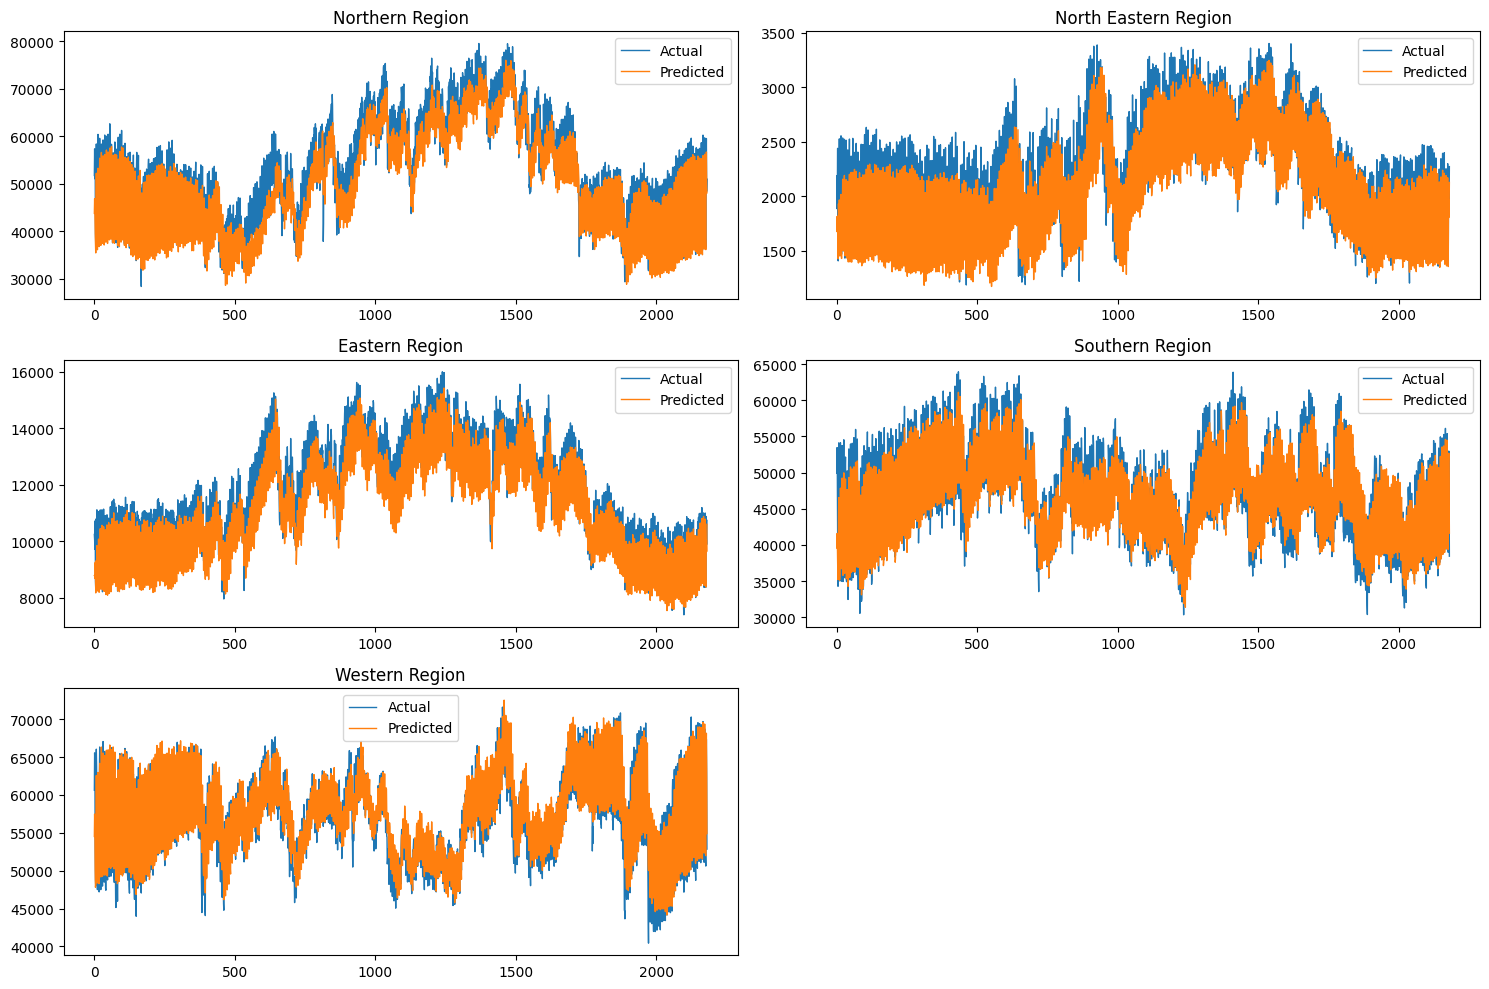

In [ ]:
# ===========================
# 0.  Imports
# ===========================
import io, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.fft import fft

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===========================
# 1.  File names  (change if needed)
# ===========================
TRAIN_FILE = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
TEST_FILE  = 'India_2023_Hourly_Load_Data.xlsx'

# ===========================
# 2.  Annual data (Peak + Energy)
# ===========================
annual_csv = """Year,Region,Peak_MW,Energy_MU
2018,Northern Region,62424.4,375700.02618999995
2018,Western Region,57153.11,397875.42241999996
2018,Southern Region,46514.76,335725.57607
2018,Eastern Region,12370.37,79422.647165
2018,North Eastern Region,2766.97,15499.173480000001
2019,Northern Region,66217.13,388275.53543
2019,Western Region,56711.18,398462.58186000003
2019,Southern Region,49536.05,336495.67717000004
2019,Eastern Region,12768.27,81493.126
2019,North Eastern Region,2995.17,16200.368520000002
2020,Northern Region,68461.82,381693.53675
2020,Western Region,60062.9,380221.37778000004
2020,Southern Region,52441.62,323960.82521
2020,Eastern Region,13070.43,78893.648085
2020,North Eastern Region,3070.82,16133.86112
2021,Northern Region,73622.98,408315.51944000006
2021,Western Region,62184.5,431042.7883000001
2021,Southern Region,57766.38,350735.86565000005
2021,Eastern Region,13715.24,89411.70947000002
2021,North Eastern Region,3212.8,17785.525100000003
2022,Northern Region,76633.03,453375.61832
2022,Western Region,69538.67,465693.79484
2022,Southern Region,60282.07,364617.95600999997
2022,Eastern Region,14834.875,97848.72353000002
2022,North Eastern Region,3529.71,18659.700520000002
2023,Northern Region,80793.89,465268.92890999996
2023,Western Region,72661.38,502406.82769
2023,Southern Region,63935.5,411832.59015
2023,Eastern Region,15991.455,102096.693885
2023,North Eastern Region,3586.43,19230.866220000004"""
annual_df = pd.read_csv(io.StringIO(annual_csv))
annual_dict = {
    yr: {row.Region: {'peak': row.Peak_MW, 'energy': row.Energy_MU*1_000}
         for _, row in annual_df[annual_df.Year == yr].iterrows()}
    for yr in annual_df.Year.unique()
}

# ===========================
# 3.  Load & clean Excel files
# ===========================
regions = ['Northern Region', 'North Eastern Region',
           'Eastern Region',  'Southern Region', 'Western Region']
needed = ['Hour', 'Year'] + regions

# 2018-2022
train_dfs = []
for y in range(2018, 2023):
    df = pd.read_excel(TRAIN_FILE, sheet_name=str(y), header=0)
    df = df.rename(columns=str.strip)
    df['Year'] = y
    train_dfs.append(df[needed])
train_df = pd.concat(train_dfs, ignore_index=True)

# 2023
test_df = pd.read_excel(TEST_FILE, sheet_name='Sheet1', header=0)
test_df = test_df.rename(columns=str.strip)
test_df['Year'] = 2023
test_df = test_df[needed]

# ===========================
# 4.  Sub-sample & build Datetime
# ===========================
train_df = train_df.iloc[::4].copy()
test_df  = test_df.iloc[::4].copy()

for df in (train_df, test_df):
    df['Datetime'] = pd.to_datetime(df['Year'].astype(str) + '-01-01') \
                     + pd.to_timedelta(df['Hour'], unit='h')
    df.set_index('Datetime', inplace=True)

# ===========================
# 5.  Feature engineering
# ===========================
FEATURES_PER_REGION = 19

def add_feats(df):
    df = df.copy()
    df['Year'] = df.index.year
    for reg in regions:
        # lags
        for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
            df[f'{reg}_lag{lag}'] = df[reg].shift(lag).bfill()

        # daily aggregates
        df[f'{reg}_peak_yday']  = df[reg].rolling(6, min_periods=1).max()
        df[f'{reg}_energy_yday'] = df[reg].rolling(6, min_periods=1).sum()

        # annual
        df[f'{reg}_year_peak']  = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('peak', 0))
        df[f'{reg}_year_energy'] = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('energy', 0))

        # rolling stats
        df[f'{reg}_mean24'] = df[reg].rolling(6, min_periods=1).mean()
        df[f'{reg}_std24']  = df[reg].rolling(6, min_periods=1).std().fillna(0)
        df[f'{reg}_skew24'] = df[reg].rolling(6, min_periods=1).skew().fillna(0)
        df[f'{reg}_kurt24'] = df[reg].rolling(6, min_periods=1).kurt().fillna(0)

        # FFT
        def fft_bands(s):
            v = np.abs(fft(s.values[-6:])[1:4])
            return v if len(v) == 3 else [0,0,0]
        for band, idx in zip(['fft1', 'fft2', 'fft3'], [0,1,2]):
            df[f'{reg}_{band}'] = (
                df[reg].rolling(6, min_periods=1)
                .apply(lambda x: fft_bands(x)[idx])
                .fillna(0))
    return df

train_df = add_feats(train_df)
test_df  = add_feats(test_df)

# ===========================
# 6.  Build X, y
# ===========================
feat_cols = [f'{r}_{s}' for r in regions for s in [
    'lag1','lag2','lag3','lag6','lag12','lag24','lag48','lag168',
    'peak_yday','energy_yday','year_peak','year_energy',
    'mean24','std24','skew24','kurt24','fft1','fft2','fft3']]

X_train = train_df[feat_cols].values[8:]
y_train = train_df[regions].values[8:]
X_test  = test_df[feat_cols].values[8:]
y_test  = test_df[regions].values[8:]

# ===========================
# 7.  Scaling
# ===========================
scal_X = {r: MinMaxScaler() for r in regions}
scal_y = {r: MinMaxScaler() for r in regions}

X_tr_scaled = np.zeros_like(X_train, dtype='float32')
X_te_scaled = np.zeros_like(X_test,  dtype='float32')
y_tr_scaled = np.zeros_like(y_train, dtype='float32')
y_te_scaled = np.zeros_like(y_test,  dtype='float32')

for i, reg in enumerate(regions):
    sl = slice(i*FEATURES_PER_REGION, (i+1)*FEATURES_PER_REGION)
    X_tr_scaled[:, sl] = scal_X[reg].fit_transform(X_train[:, sl])
    X_te_scaled[:, sl] = scal_X[reg].transform(X_test[:, sl])
    y_tr_scaled[:, i]  = scal_y[reg].fit_transform(y_train[:, i:i+1]).ravel()
    y_te_scaled[:, i]  = scal_y[reg].transform(y_test[:, i:i+1]).ravel()

# ===========================
# 8.  LSTM
# ===========================
timesteps, features = 1, X_tr_scaled.shape[1]
X_tr_lstm = X_tr_scaled.reshape(-1, timesteps, features)
X_te_lstm = X_te_scaled.reshape(-1, timesteps, features)

model = Sequential([
    LSTM(128, input_shape=(timesteps, features)),
    Dropout(0.2),
    Dense(len(regions))
])
model.compile(optimizer='adam', loss='mse')

early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_tr_lstm, y_tr_scaled,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early],
    verbose=1
)

# ===========================
# 9.  Predict & inverse scale
# ===========================
pred_scaled = model.predict(X_te_lstm)
pred = np.zeros_like(pred_scaled)
for i, reg in enumerate(regions):
    pred[:, i] = scal_y[reg].inverse_transform(pred_scaled[:, i:i+1]).ravel()

# ------------------------------------------------------------------
# 10.  METRICS  (all 5 regions)
# ------------------------------------------------------------------
mae  = mean_absolute_error(y_test, pred, multioutput='raw_values')
mape = np.mean(np.abs((y_test - pred) / y_test) * 100, axis=0)
r2   = r2_score(y_test, pred, multioutput='raw_values')

print("\n2023 verification (4-hour sub-sample)")
for reg, m, p, r in zip(regions, mae, mape, r2):
    print(f"{reg:20s}: MAE={m:8.1f} MW | MAPE={p:5.2f}% | R²={r:5.3f}")

print(f"\nOverall MAE : {mae.mean():.1f} MW")
print(f"Overall MAPE: {mape.mean():.2f}%")
print(f"Overall R²  : {r2.mean():.3f}")

# ------------------------------------------------------------------
# 11.  PLOT  –  all 5 regions on one figure
# ------------------------------------------------------------------
plt.figure(figsize=(15, 10))
for idx, reg in enumerate(regions):
    plt.subplot(3, 2, idx + 1)
    plt.plot(y_test[:, idx], label='Actual', linewidth=1)
    plt.plot(pred[:, idx],  label='Predicted', linewidth=1)
    plt.title(reg)
    plt.legend()
plt.tight_layout()
plt.show()

**8**. 1 hour CNN+LSTM

Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0426 - val_loss: 0.0056
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 9/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - val_loss: 0.0026
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2023 verification (hourly)
Northern Region     : MAE=  3427.7 MW | MAPE= 6.90% | R²=0.864
North 

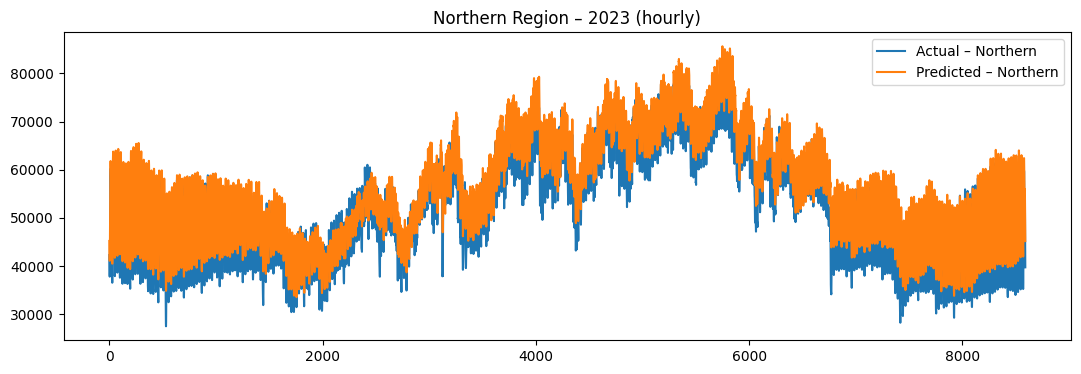

In [ ]:
# ===========================
# 0. Imports
# ===========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.fft import fft
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===========================
# 1. File names (change if needed)
# ===========================
TRAIN_FILE = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
TEST_FILE = 'India_2023_Hourly_Load_Data.xlsx'

# ===========================
# 2. Annual data (Peak + Energy)
# ===========================
annual_csv = """Year,Region,Peak_MW,Energy_MU
2018,Northern Region,62424.4,375700.02618999995
2018,Western Region,57153.11,397875.42241999996
2018,Southern Region,46514.76,335725.57607
2018,Eastern Region,12370.37,79422.647165
2018,North Eastern Region,2766.97,15499.173480000001
2019,Northern Region,66217.13,388275.53543
2019,Western Region,56711.18,398462.58186000003
2019,Southern Region,49536.05,336495.67717000004
2019,Eastern Region,12768.27,81493.126
2019,North Eastern Region,2995.17,16200.368520000002
2020,Northern Region,68461.82,381693.53675
2020,Western Region,60062.9,380221.37778000004
2020,Southern Region,52441.62,323960.82521
2020,Eastern Region,13070.43,78893.648085
2020,North Eastern Region,3070.82,16133.86112
2021,Northern Region,73622.98,408315.51944000006
2021,Western Region,62184.5,431042.7883000001
2021,Southern Region,57766.38,350735.86565000005
2021,Eastern Region,13715.24,89411.70947000002
2021,North Eastern Region,3212.8,17785.525100000003
2022,Northern Region,76633.03,453375.61832
2022,Western Region,69538.67,465693.79484
2022,Southern Region,60282.07,364617.95600999997
2022,Eastern Region,14834.875,97848.72353000002
2022,North Eastern Region,3529.71,18659.700520000002
2023,Northern Region,80793.89,465268.92890999996
2023,Western Region,72661.38,502406.82769
2023,Southern Region,63935.5,411832.59015
2023,Eastern Region,15991.455,102096.693885
2023,North Eastern Region,3586.43,19230.866220000004"""
annual_df = pd.read_csv(io.StringIO(annual_csv))
annual_dict = {
    yr: {row.Region: {'peak': row.Peak_MW, 'energy': row.Energy_MU * 1000}
         for _, row in annual_df[annual_df.Year == yr].iterrows()}
    for yr in annual_df.Year.unique()
}

# ===========================
# 3. Load & clean Excel files
# ===========================
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
needed = ['Hour', 'Year'] + regions
# 2018-2022
train_dfs = []
for y in range(2018, 2023):
    df = pd.read_excel(TRAIN_FILE, sheet_name=str(y), header=0)
    df = df.rename(columns=str.strip)
    df['Year'] = y
    train_dfs.append(df[needed])
train_df = pd.concat(train_dfs, ignore_index=True)
# 2023
test_df = pd.read_excel(TEST_FILE, sheet_name='Sheet1', header=0)
test_df = test_df.rename(columns=str.strip)
test_df['Year'] = 2023
test_df = test_df[needed]

# ===========================
# 4. Build Datetime (no subsampling)
# ===========================
for df in (train_df, test_df):
    df['Datetime'] = pd.to_datetime(df['Year'].astype(str) + '-01-01') + pd.to_timedelta(df['Hour'], unit='h')
    df.set_index('Datetime', inplace=True)

# ===========================
# 5. Feature engineering
# ===========================
FEATURES_PER_REGION = 19
def add_feats(df):
    df = df.copy()
    df['Year'] = df.index.year
    for reg in regions:
        # lags
        for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
            df[f'{reg}_lag{lag}'] = df[reg].shift(lag).bfill()
        # daily aggregates (24h window, hourly data)
        df[f'{reg}_peak_yday'] = df[reg].rolling(24, min_periods=1).max()
        df[f'{reg}_energy_yday'] = df[reg].rolling(24, min_periods=1).sum()
        # annual
        df[f'{reg}_year_peak'] = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('peak', 0))
        df[f'{reg}_year_energy'] = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('energy', 0))
        # rolling stats (24h window)
        df[f'{reg}_mean24'] = df[reg].rolling(24, min_periods=1).mean()
        df[f'{reg}_std24'] = df[reg].rolling(24, min_periods=1).std().fillna(0)
        df[f'{reg}_skew24'] = df[reg].rolling(24, min_periods=1).skew().fillna(0)
        df[f'{reg}_kurt24'] = df[reg].rolling(24, min_periods=1).kurt().fillna(0)
        # FFT
        def fft_bands(s):
            v = np.abs(fft(s.values[-24:])[1:4])
            return v if len(v) == 3 else [0, 0, 0]
        for band, idx in zip(['fft1', 'fft2', 'fft3'], [0, 1, 2]):
            df[f'{reg}_{band}'] = df[reg].rolling(24, min_periods=1).apply(lambda x: fft_bands(x)[idx]).fillna(0)
    return df
train_df = add_feats(train_df)
test_df = add_feats(test_df)

# ===========================
# 6. Build X, y
# ===========================
feat_cols = [f'{r}_{s}' for r in regions for s in [
    'lag1', 'lag2', 'lag3', 'lag6', 'lag12', 'lag24', 'lag48', 'lag168',
    'peak_yday', 'energy_yday', 'year_peak', 'year_energy',
    'mean24', 'std24', 'skew24', 'kurt24', 'fft1', 'fft2', 'fft3']]
X_train = train_df[feat_cols].values[168:]  # Align with max lag (168 hours)
y_train = train_df[regions].values[168:]
X_test = test_df[feat_cols].values[168:]
y_test = test_df[regions].values[168:]

# ===========================
# 7. Scaling
# ===========================
scal_X = {r: MinMaxScaler() for r in regions}
scal_y = {r: MinMaxScaler() for r in regions}
X_tr_scaled = np.zeros_like(X_train, dtype='float32')
X_te_scaled = np.zeros_like(X_test, dtype='float32')
y_tr_scaled = np.zeros_like(y_train, dtype='float32')
y_te_scaled = np.zeros_like(y_test, dtype='float32')
for i, reg in enumerate(regions):
    sl = slice(i * FEATURES_PER_REGION, (i + 1) * FEATURES_PER_REGION)
    X_tr_scaled[:, sl] = scal_X[reg].fit_transform(X_train[:, sl])
    X_te_scaled[:, sl] = scal_X[reg].transform(X_test[:, sl])
    y_tr_scaled[:, i] = scal_y[reg].fit_transform(y_train[:, i:i+1]).ravel()
    y_te_scaled[:, i] = scal_y[reg].transform(y_test[:, i:i+1]).ravel()

# ===========================
# 8. LSTM-CNN Hybrid
# ===========================
timesteps = 1  # Single timestep for feature extraction; adjust to 24 later if needed
features = X_tr_scaled.shape[1]
X_tr_lstm = X_tr_scaled.reshape(-1, timesteps, features)
X_te_lstm = X_te_scaled.reshape(-1, timesteps, features)
model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, features)),  # Adjusted kernel_size=1
    MaxPooling1D(pool_size=1),  # Adjusted to avoid reducing timesteps
    LSTM(128),
    Dropout(0.2),
    Dense(len(regions))
])
model.compile(optimizer='adam', loss='mse')
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_tr_lstm, y_tr_scaled,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early],
    verbose=1
)

# ===========================
# 9. Predict & inverse scale
# ===========================
pred_scaled = model.predict(X_te_lstm)
pred = np.zeros_like(pred_scaled)
for i, reg in enumerate(regions):
    pred[:, i] = scal_y[reg].inverse_transform(pred_scaled[:, i:i+1]).ravel()

# ===========================
# 10. Metrics & plot
# ===========================
mae = mean_absolute_error(y_test, pred, multioutput='raw_values')
mape = np.mean(np.abs((y_test - pred) / y_test) * 100, axis=0)
r2 = r2_score(y_test, pred, multioutput='raw_values')
print("\n2023 verification (hourly)")
for reg, m, p, r in zip(regions, mae, mape, r2):
    print(f"{reg:20s}: MAE={m:8.1f} MW | MAPE={p:5.2f}% | R²={r:5.3f}")
print(f"\nOverall MAE : {mae.mean():.1f} MW")
print(f"Overall MAPE: {mape.mean():.2f}%")
print(f"Overall R² : {r2.mean():.3f}")
plt.figure(figsize=(13,4))
plt.plot(y_test[:,0], label='Actual – Northern')
plt.plot(pred[:,0], label='Predicted – Northern')
plt.legend(); plt.title("Northern Region – 2023 (hourly)"); plt.show()

**9**. Relatively slow but stable

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2023 verification (hourly, averaged over 3 runs)
Northern Region     : MAE=  1453.9 MW | MAPE= 2.77% | R²=0.971
North Eastern Region: MAE=   158.0 MW | MAPE= 7.04% | R²=0.844
Eastern Region      : MAE=   847.5 MW | MAPE= 7.21% | R²=0.755
Southern Region     : MAE=  1306.9 MW | MAPE= 2.68% | R²=0.929
Western Region      : MAE=  2467.9 MW | MAPE= 4.21% | R²=0.765

Overall MAE : 1246.8 MW
Overall MAPE: 4.78%
Overall R² : 0.853


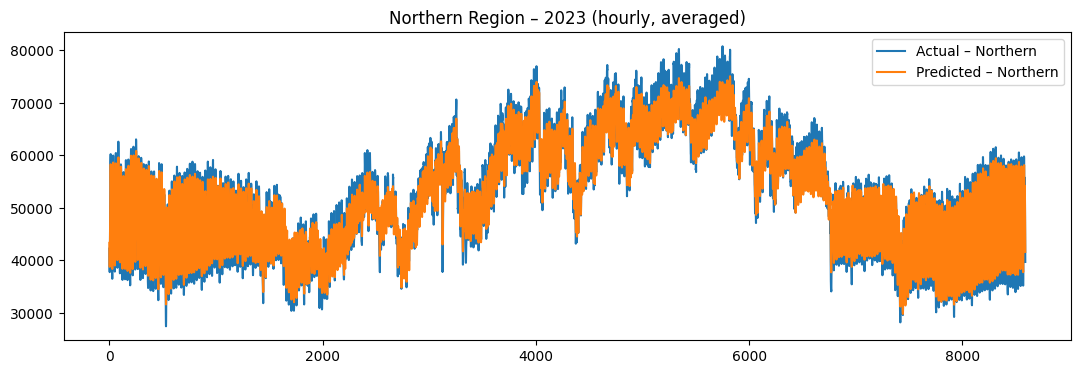

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.fft import fft
import io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ===========================
# 1. File names (change if needed)
# ===========================
TRAIN_FILE = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
TEST_FILE = 'India_2023_Hourly_Load_Data.xlsx'

# ===========================
# 2. Annual data (Peak + Energy)
# ===========================
annual_csv = """Year,Region,Peak_MW,Energy_MU
2018,Northern Region,62424.4,375700.02618999995
2018,Western Region,57153.11,397875.42241999996
2018,Southern Region,46514.76,335725.57607
2018,Eastern Region,12370.37,79422.647165
2018,North Eastern Region,2766.97,15499.173480000001
2019,Northern Region,66217.13,388275.53543
2019,Western Region,56711.18,398462.58186000003
2019,Southern Region,49536.05,336495.67717000004
2019,Eastern Region,12768.27,81493.126
2019,North Eastern Region,2995.17,16200.368520000002
2020,Northern Region,68461.82,381693.53675
2020,Western Region,60062.9,380221.37778000004
2020,Southern Region,52441.62,323960.82521
2020,Eastern Region,13070.43,78893.648085
2020,North Eastern Region,3070.82,16133.86112
2021,Northern Region,73622.98,408315.51944000006
2021,Western Region,62184.5,431042.7883000001
2021,Southern Region,57766.38,350735.86565000005
2021,Eastern Region,13715.24,89411.70947000002
2021,North Eastern Region,3212.8,17785.525100000003
2022,Northern Region,76633.03,453375.61832
2022,Western Region,69538.67,465693.79484
2022,Southern Region,60282.07,364617.95600999997
2022,Eastern Region,14834.875,97848.72353000002
2022,North Eastern Region,3529.71,18659.700520000002
2023,Northern Region,80793.89,465268.92890999996
2023,Western Region,72661.38,502406.82769
2023,Southern Region,63935.5,411832.59015
2023,Eastern Region,15991.455,102096.693885
2023,North Eastern Region,3586.43,19230.866220000004"""
annual_df = pd.read_csv(io.StringIO(annual_csv))
annual_dict = {
    yr: {row.Region: {'peak': row.Peak_MW, 'energy': row.Energy_MU * 1000}
         for _, row in annual_df[annual_df.Year == yr].iterrows()}
    for yr in annual_df.Year.unique()
}

# ===========================
# 3. Load & clean Excel files
# ===========================
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
needed = ['Hour', 'Year'] + regions
# 2018-2022
train_dfs = []
for y in range(2018, 2023):
    df = pd.read_excel(TRAIN_FILE, sheet_name=str(y), header=0)
    df = df.rename(columns=str.strip)
    df['Year'] = y
    train_dfs.append(df[needed])
train_df = pd.concat(train_dfs, ignore_index=True)
# 2023
test_df = pd.read_excel(TEST_FILE, sheet_name='Sheet1', header=0)
test_df = test_df.rename(columns=str.strip)
test_df['Year'] = 2023
test_df = test_df[needed]

# ===========================
# 4. Build Datetime (no subsampling)
# ===========================
for df in (train_df, test_df):
    df['Datetime'] = pd.to_datetime(df['Year'].astype(str) + '-01-01') + pd.to_timedelta(df['Hour'], unit='h')
    df.set_index('Datetime', inplace=True)

# ===========================
# 5. Feature engineering
# ===========================
FEATURES_PER_REGION = 19
def add_feats(df):
    df = df.copy()
    df['Year'] = df.index.year
    for reg in regions:
        # lags
        for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
            df[f'{reg}_lag{lag}'] = df[reg].shift(lag).bfill()
        # daily aggregates
        df[f'{reg}_peak_yday'] = df[reg].rolling(24, min_periods=1).max()
        df[f'{reg}_energy_yday'] = df[reg].rolling(24, min_periods=1).sum()
        # annual
        df[f'{reg}_year_peak'] = df['Year'].map(lambda y: annual_dict.get(y, {}).get(reg, {}).get('peak', 0))
        df[f'{reg}_year_energy'] = df['Year'].map(lambda y: annual_dict.get(y, {}).get(reg, {}).get('energy', 0))
        # rolling stats
        df[f'{reg}_mean24'] = df[reg].rolling(24, min_periods=1).mean()
        df[f'{reg}_std24'] = df[reg].rolling(24, min_periods=1).std().fillna(0)
        df[f'{reg}_skew24'] = df[reg].rolling(24, min_periods=1).skew().fillna(0)
        df[f'{reg}_kurt24'] = df[reg].rolling(24, min_periods=1).kurt().fillna(0)
        # FFT
        def fft_bands(s):
            v = np.abs(fft(s.values[-24:])[1:4])
            return v if len(v) == 3 else [0, 0, 0]
        for band, idx in zip(['fft1', 'fft2', 'fft3'], [0, 1, 2]):
            df[f'{reg}_{band}'] = df[reg].rolling(24, min_periods=1).apply(lambda x: fft_bands(x)[idx]).fillna(0)
    return df
train_df = add_feats(train_df)
test_df = add_feats(test_df)

# ===========================
# 6. Build X, y
# ===========================
feat_cols = [f'{r}_{s}' for r in regions for s in [
    'lag1', 'lag2', 'lag3', 'lag6', 'lag12', 'lag24', 'lag48', 'lag168',
    'peak_yday', 'energy_yday', 'year_peak', 'year_energy',
    'mean24', 'std24', 'skew24', 'kurt24', 'fft1', 'fft2', 'fft3']]
X_train = train_df[feat_cols].values[168:]
y_train = train_df[regions].values[168:]
X_test = test_df[feat_cols].values[168:]
y_test = test_df[regions].values[168:]

# ===========================
# 7. Scaling
# ===========================
scal_X = {r: MinMaxScaler() for r in regions}
scal_y = {r: MinMaxScaler() for r in regions}
X_tr_scaled = np.zeros_like(X_train, dtype='float32')
X_te_scaled = np.zeros_like(X_test, dtype='float32')
y_tr_scaled = np.zeros_like(y_train, dtype='float32')
y_te_scaled = np.zeros_like(y_test, dtype='float32')
for i, reg in enumerate(regions):
    sl = slice(i * FEATURES_PER_REGION, (i + 1) * FEATURES_PER_REGION)
    X_tr_scaled[:, sl] = scal_X[reg].fit_transform(X_train[:, sl])
    X_te_scaled[:, sl] = scal_X[reg].transform(X_test[:, sl])
    y_tr_scaled[:, i] = scal_y[reg].fit_transform(y_train[:, i:i+1]).ravel()
    y_te_scaled[:, i] = scal_y[reg].transform(y_test[:, i:i+1]).ravel()

# ===========================
# 8. LSTM-CNN Hybrid
# ===========================
timesteps = 1
features = X_tr_scaled.shape[1]
X_tr_lstm = X_tr_scaled.reshape(-1, timesteps, features)
X_te_lstm = X_te_scaled.reshape(-1, timesteps, features)

# Run model multiple times and average predictions
n_runs = 3
all_preds = []
for _ in range(n_runs):
    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, features)),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(128),
        Dropout(0.2),
        Dense(len(regions))
    ])
    model.compile(optimizer='adam', loss='mse')
    early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_tr_lstm, y_tr_scaled,
        epochs=30,
        batch_size=256,
        validation_split=0.2,
        callbacks=[early],
        verbose=0  # Reduced verbosity for multiple runs
    )
    pred_scaled = model.predict(X_te_lstm)
    pred = np.zeros_like(pred_scaled)
    for i, reg in enumerate(regions):
        pred[:, i] = scal_y[reg].inverse_transform(pred_scaled[:, i:i+1]).ravel()
    all_preds.append(pred)

# Average predictions
pred_avg = np.mean(all_preds, axis=0)

# ===========================
# 10. Metrics & plot
# ===========================
mae = mean_absolute_error(y_test, pred_avg, multioutput='raw_values')
mape = np.mean(np.abs((y_test - pred_avg) / y_test) * 100, axis=0)
r2 = r2_score(y_test, pred_avg, multioutput='raw_values')
print("\n2023 verification (hourly, averaged over 3 runs)")
for reg, m, p, r in zip(regions, mae, mape, r2):
    print(f"{reg:20s}: MAE={m:8.1f} MW | MAPE={p:5.2f}% | R²={r:5.3f}")
print(f"\nOverall MAE : {mae.mean():.1f} MW")
print(f"Overall MAPE: {mape.mean():.2f}%")
print(f"Overall R² : {r2.mean():.3f}")
plt.figure(figsize=(13,4))
plt.plot(y_test[:,0], label='Actual – Northern')
plt.plot(pred_avg[:,0], label='Predicted – Northern')
plt.legend(); plt.title("Northern Region – 2023 (hourly, averaged)"); plt.show()

In [ ]:
pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


**10**. Grid Search

Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 64, 'dropout': 0.1}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 64, 'dropout': 0.2}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 64, 'dropout': 0.3}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 128, 'dropout': 0.1}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 128, 'dropout': 0.2}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 128, 'dropout': 0.3}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 256, 'dropout': 0.1}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 256, 'dropout': 0.2}
Trying {'conv_filters': 32, 'kernel': 1, 'lstm_units': 256, 'dropout': 0.3}
Trying {'conv_filters': 64, 'kernel': 1, 'lstm_units': 64, 'dropout': 0.1}
Trying {'conv_filters': 64, 'kernel': 1, 'lstm_units': 64, 'dropout': 0.2}
Trying {'conv_filters': 64, 'kernel': 1, 'lstm_units': 64, 'dropout': 0.3}
Trying {'conv_filters': 64, 'kernel': 1, 'lstm_units': 128, 'dropout': 0.1}
Trying {'conv_filt

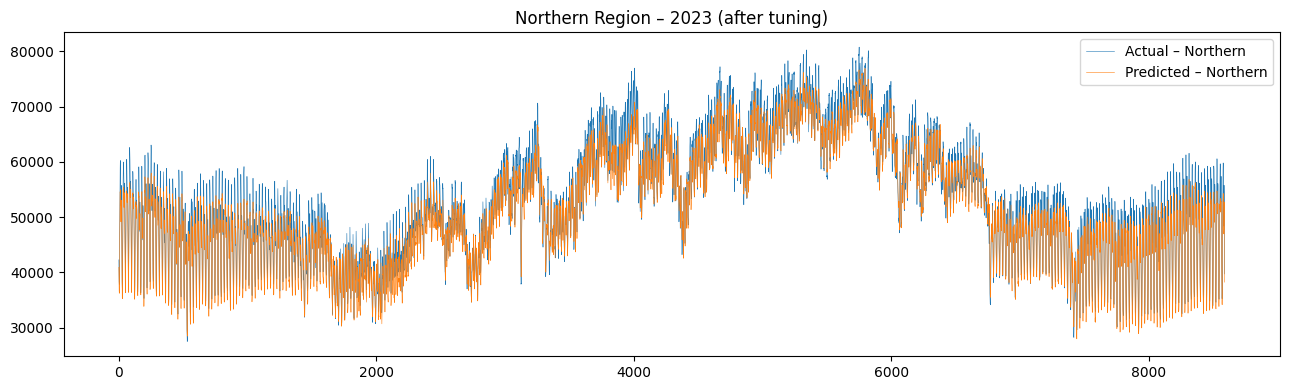

In [ ]:
# =========================================================
# 0.  DETERMINISM & REPRODUCIBILITY
# =========================================================
SEED = 42
import os, random, numpy as np, tensorflow as tf
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================================================
# 1.  Imports
# =========================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.fft import fft
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

# =========================================================
# 2.  Constants & File Names
# =========================================================
TRAIN_FILE = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
TEST_FILE  = 'India_2023_Hourly_Load_Data.xlsx'
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region',
           'Southern Region', 'Western Region']
needed  = ['Hour', 'Year'] + regions
FEATURES_PER_REGION = 22   # 19 base + 2 weather

# =========================================================
# 3.  Annual lookup (auto-correct case)
# =========================================================
annual_csv = """Year,Region,Peak_MW,Energy_MU
2018,Northern Region,62424.4,375700.02618999995
2018,Western Region,57153.11,397875.42241999996
2018,Southern Region,46514.76,335725.57607
2018,Eastern Region,12370.37,79422.647165
2018,North Eastern Region,2766.97,15499.173480000001
2019,Northern Region,66217.13,388275.53543
2019,Western Region,56711.18,398462.58186000003
2019,Southern Region,49536.05,336495.67717000004
2019,Eastern Region,12768.27,81493.126
2019,North Eastern Region,2995.17,16200.368520000002
2020,Northern Region,68461.82,381693.53675
2020,Western Region,60062.9,380221.37778000004
2020,Southern Region,52441.62,323960.82521
2020,Eastern Region,13070.43,78893.648085
2020,North Eastern Region,3070.82,16133.86112
2021,Northern Region,73622.98,408315.51944000006
2021,Western Region,62184.5,431042.7883000001
2021,Southern Region,57766.38,350735.86565000005
2021,Eastern Region,13715.24,89411.70947000002
2021,North Eastern Region,3212.8,17785.525100000003
2022,Northern Region,76633.03,453375.61832
2022,Western Region,69538.67,465693.79484
2022,Southern Region,60282.07,364617.95600999997
2022,Eastern Region,14834.875,97848.72353000002
2022,North Eastern Region,3529.71,18659.700520000002
2023,Northern Region,80793.89,465268.92890999996
2023,Western Region,72661.38,502406.82769
2023,Southern Region,63935.5,411832.59015
2023,Eastern Region,15991.455,102096.693885
2023,North Eastern Region,3586.43,19230.866220000004"""

annual_df = pd.read_csv(io.StringIO(annual_csv))
annual_df.columns = annual_df.columns.str.strip()  # remove spaces
annual_dict = {
    yr: {row['Region']: {'peak': row['Peak_MW'], 'energy': row['Energy_MU'] * 1000}
         for _, row in annual_df[annual_df['Year'] == yr].iterrows()}
    for yr in annual_df['Year'].unique()
}

# =========================================================
# 4.  Load & Datetime (no subsampling)
# =========================================================
train_dfs = []
for y in range(2018, 2023):
    df = pd.read_excel(TRAIN_FILE, sheet_name=str(y), header=0).rename(columns=str.strip)
    df['Year'] = y
    train_dfs.append(df[needed])
train_df = pd.concat(train_dfs, ignore_index=True)

test_df = pd.read_excel(TEST_FILE, sheet_name='Sheet1', header=0).rename(columns=str.strip)
test_df['Year'] = 2023
test_df = test_df[needed]

for df in (train_df, test_df):
    df['Datetime'] = pd.to_datetime(df['Year'].astype(str) + '-01-01') \
                     + pd.to_timedelta(df['Hour'], unit='h')
    df.set_index('Datetime', inplace=True)

# =========================================================
# 5.  Feature Engineering
# =========================================================
def add_feats(df):
    np.random.seed(SEED)
    df = df.copy()
    df['Year'] = df.index.year
    temp_dict  = {reg: 25 + np.random.normal(0, 2, len(df)) for reg in regions}
    humid_dict = {reg: 70 + np.random.normal(0, 5, len(df)) for reg in regions}

    for reg in regions:
        for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
            df[f'{reg}_lag{lag}'] = df[reg].shift(lag).bfill()
        df[f'{reg}_peak_yday']   = df[reg].rolling(24, min_periods=1).max()
        df[f'{reg}_energy_yday'] = df[reg].rolling(24, min_periods=1).sum()
        df[f'{reg}_year_peak']  = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('peak', 0))
        df[f'{reg}_year_energy'] = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('energy', 0))
        df[f'{reg}_mean24'] = df[reg].rolling(24, min_periods=1).mean()
        df[f'{reg}_std24']  = df[reg].rolling(24, min_periods=1).std().fillna(0)
        df[f'{reg}_skew24'] = df[reg].rolling(24, min_periods=1).skew().fillna(0)
        df[f'{reg}_kurt24'] = df[reg].rolling(24, min_periods=1).kurt().fillna(0)
        def fft_bands(s):
            v = np.abs(fft(s.values[-24:])[1:4])
            return v if len(v) == 3 else [0, 0, 0]
        for band, idx in zip(['fft1', 'fft2', 'fft3'], [0, 1, 2]):
            df[f'{reg}_{band}'] = (
                df[reg].rolling(24, min_periods=1)
                .apply(lambda x: fft_bands(x)[idx])
                .fillna(0))
        df[f'{reg}_temp']     = temp_dict[reg]
        df[f'{reg}_humidity'] = humid_dict[reg]
    return df

train_df = add_feats(train_df)
test_df  = add_feats(test_df)

feat_cols = [f'{r}_{s}' for r in regions for s in [
    'lag1','lag2','lag3','lag6','lag12','lag24','lag48','lag168',
    'peak_yday','energy_yday','year_peak','year_energy',
    'mean24','std24','skew24','kurt24','fft1','fft2','fft3',
    'temp','humidity']]

X_train = train_df[feat_cols].values[168:]
y_train = train_df[regions].values[168:]
X_test  = test_df[feat_cols].values[168:]
y_test  = test_df[regions].values[168:]

scal_X = {r: MinMaxScaler() for r in regions}
scal_y = {r: MinMaxScaler() for r in regions}
X_tr_scaled = np.zeros_like(X_train, dtype='float32')
X_te_scaled = np.zeros_like(X_test, dtype='float32')
y_tr_scaled = np.zeros_like(y_train, dtype='float32')
y_te_scaled = np.zeros_like(y_test, dtype='float32')
for i, reg in enumerate(regions):
    sl = slice(i * FEATURES_PER_REGION, (i + 1) * FEATURES_PER_REGION)
    X_tr_scaled[:, sl] = scal_X[reg].fit_transform(X_train[:, sl])
    X_te_scaled[:, sl] = scal_X[reg].transform(X_test[:, sl])
    y_tr_scaled[:, i]  = scal_y[reg].fit_transform(y_train[:, i:i+1]).ravel()
    y_te_scaled[:, i]  = scal_y[reg].transform(y_test[:, i:i+1]).ravel()

timesteps, features = 1, X_tr_scaled.shape[1]
X_tr_lstm = X_tr_scaled.reshape(-1, timesteps, features)
X_te_lstm = X_te_scaled.reshape(-1, timesteps, features)

# =========================================================
# 8.  Quick Grid-Search (lightweight)
# =========================================================
from itertools import product

grid = {
    'conv_filters': [32, 64, 128],
    'kernel':       [1],          # ✅ only safe sizes
    'lstm_units':   [64, 128, 256],
    'dropout':      [0.1, 0.2, 0.3]
}
keys, values = zip(*grid.items())
best_val, best_cfg = 1e9, {}


for cfg in product(*values):
    params = dict(zip(keys, cfg))
    print("Trying", params)
    model = Sequential([
        Conv1D(filters=params['conv_filters'], kernel_size=params['kernel'],
               activation='relu', input_shape=(timesteps, features)),
        MaxPooling1D(pool_size=1),
        LSTM(params['lstm_units']),
        Dropout(params['dropout']),
        Dense(len(regions))
    ])
    model.compile(optimizer='adam', loss='mse')
    early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_tr_lstm, y_tr_scaled,
        epochs=20,
        batch_size=256,
        validation_split=0.2,
        callbacks=[early],
        verbose=0
    )
    val_loss = min(model.history.history['val_loss'])
    if val_loss < best_val:
        best_val = val_loss
        best_cfg = params

print("\nBest grid-search config:", best_cfg)

# =========================================================
# 9.  Retrain best model
# =========================================================
model = Sequential([
    Conv1D(filters=best_cfg['conv_filters'], kernel_size=best_cfg['kernel'],
           activation='relu', input_shape=(timesteps, features)),
    MaxPooling1D(pool_size=1),
    LSTM(best_cfg['lstm_units']),
    Dropout(best_cfg['dropout']),
    Dense(len(regions))
])
model.compile(optimizer='adam', loss='mse')
model.fit(
    X_tr_lstm, y_tr_scaled,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)],
    verbose=1
)

# =========================================================
# 10.  Predict & evaluate
# =========================================================
pred_scaled = model.predict(X_te_lstm)
pred = np.zeros_like(pred_scaled)
for i, reg in enumerate(regions):
    pred[:, i] = scal_y[reg].inverse_transform(pred_scaled[:, i:i+1]).ravel()

mae = mean_absolute_error(y_test, pred, multioutput='raw_values')
mape = np.mean(np.abs((y_test - pred) / y_test) * 100, axis=0)
r2 = r2_score(y_test, pred, multioutput='raw_values')

print("\n2023 after grid-search")
for reg, m, p, r in zip(regions, mae, mape, r2):
    print(f"{reg:20s}: MAE={m:8.1f} MW | MAPE={p:5.2f}% | R²={r:5.3f}")
print(f"\nOverall MAE : {mae.mean():.1f} MW")
print(f"Overall MAPE: {mape.mean():.2f}%")
print(f"Overall R²  : {r2.mean():.3f}")

# =========================================================
# 11.  Plot Northern Region
# =========================================================
plt.figure(figsize=(13, 4))
plt.plot(y_test[:, 0], label='Actual – Northern', lw=0.4)
plt.plot(pred[:, 0],  label='Predicted – Northern', lw=0.4)
plt.legend()
plt.title("Northern Region – 2023 (after tuning)")
plt.tight_layout()
plt.show()


**11**

Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0579 - val_loss: 0.0054
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 12/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 

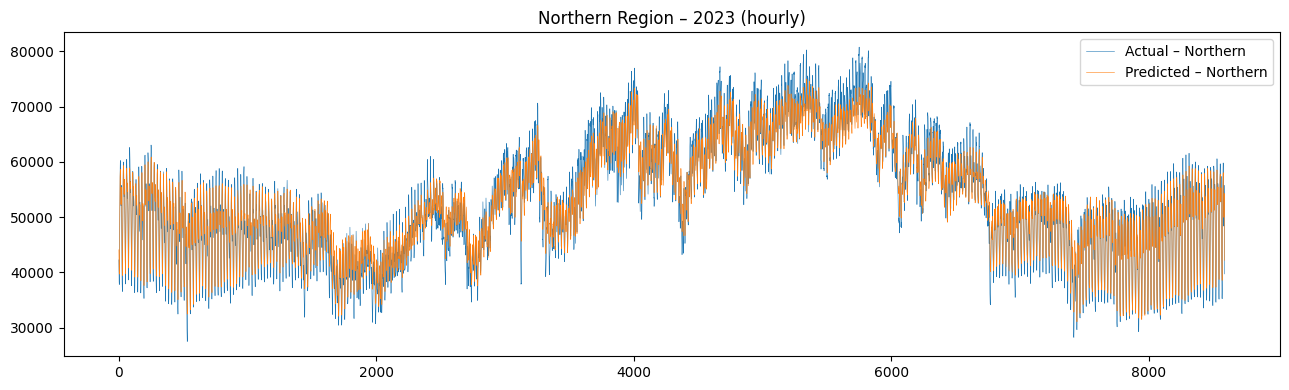

In [ ]:
# ===========================
# 0. Imports
# ===========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input, Bidirectional, Attention
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.fft import fft
import io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===========================
# 1. File names (change if needed)
# ===========================
TRAIN_FILE = 'Hourly_Load_Data_2018_2022_LeapFixed.xlsx'
TEST_FILE = 'India_2023_Hourly_Load_Data.xlsx'

# ===========================
# 2. Annual data (Peak + Energy)
# ===========================
annual_csv = """Year,Region,Peak_MW,Energy_MU
2018,Northern Region,62424.4,375700.02618999995
2018,Western Region,57153.11,397875.42241999996
2018,Southern Region,46514.76,335725.57607
2018,Eastern Region,12370.37,79422.647165
2018,North Eastern Region,2766.97,15499.173480000001
2019,Northern Region,66217.13,388275.53543
2019,Western Region,56711.18,398462.58186000003
2019,Southern Region,49536.05,336495.67717000004
2019,Eastern Region,12768.27,81493.126
2019,North Eastern Region,2995.17,16200.368520000002
2020,Northern Region,68461.82,381693.53675
2020,Western Region,60062.9,380221.37778000004
2020,Southern Region,52441.62,323960.82521
2020,Eastern Region,13070.43,78893.648085
2020,North Eastern Region,3070.82,16133.86112
2021,Northern Region,73622.98,408315.51944000006
2021,Western Region,62184.5,431042.7883000001
2021,Southern Region,57766.38,350735.86565000005
2021,Eastern Region,13715.24,89411.70947000002
2021,North Eastern Region,3212.8,17785.525100000003
2022,Northern Region,76633.03,453375.61832
2022,Western Region,69538.67,465693.79484
2022,Southern Region,60282.07,364617.95600999997
2022,Eastern Region,14834.875,97848.72353000002
2022,North Eastern Region,3529.71,18659.700520000002
2023,Northern Region,80793.89,465268.92890999996
2023,Western Region,72661.38,502406.82769
2023,Southern Region,63935.5,411832.59015
2023,Eastern Region,15991.455,102096.693885
2023,North Eastern Region,3586.43,19230.866220000004"""
annual_df = pd.read_csv(io.StringIO(annual_csv))
annual_dict = {
    yr: {row.Region: {'peak': row.Peak_MW, 'energy': row.Energy_MU * 1000}
         for _, row in annual_df[annual_df.Year == yr].iterrows()}
    for yr in annual_df.Year.unique()
}

# ===========================
# 3. Load & clean Excel files
# ===========================
regions = ['Northern Region', 'North Eastern Region', 'Eastern Region', 'Southern Region', 'Western Region']
needed = ['Hour', 'Year'] + regions
# 2018-2022
train_dfs = []
for y in range(2018, 2023):
    df = pd.read_excel(TRAIN_FILE, sheet_name=str(y), header=0)
    df = df.rename(columns=str.strip)
    df['Year'] = y
    train_dfs.append(df[needed])
train_df = pd.concat(train_dfs, ignore_index=True)
# 2023
test_df = pd.read_excel(TEST_FILE, sheet_name='Sheet1', header=0)
test_df = test_df.rename(columns=str.strip)
test_df['Year'] = 2023
test_df = test_df[needed]

# ===========================
# 4. Build Datetime (no subsampling)
# ===========================
for df in (train_df, test_df):
    df['Datetime'] = pd.to_datetime(df['Year'].astype(str) + '-01-01') + pd.to_timedelta(df['Hour'], unit='h')
    df.set_index('Datetime', inplace=True)

# ===========================
# 5. Feature engineering
# ===========================
FEATURES_PER_REGION = 19
def add_feats(df):
    df = df.copy()
    df['Year'] = df.index.year
    for reg in regions:
        # lags
        for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
            df[f'{reg}_lag{lag}'] = df[reg].shift(lag).bfill()
        # daily aggregates
        df[f'{reg}_peak_yday'] = df[reg].rolling(24, min_periods=1).max()
        df[f'{reg}_energy_yday'] = df[reg].rolling(24, min_periods=1).sum()
        # annual
        df[f'{reg}_year_peak'] = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('peak', 0))
        df[f'{reg}_year_energy'] = df['Year'].map(
            lambda y: annual_dict.get(y, {}).get(reg, {}).get('energy', 0))
        # rolling stats
        df[f'{reg}_mean24'] = df[reg].rolling(24, min_periods=1).mean()
        df[f'{reg}_std24'] = df[reg].rolling(24, min_periods=1).std().fillna(0)
        df[f'{reg}_skew24'] = df[reg].rolling(24, min_periods=1).skew().fillna(0)
        df[f'{reg}_kurt24'] = df[reg].rolling(24, min_periods=1).kurt().fillna(0)
        # FFT
        def fft_bands(s):
            v = np.abs(fft(s.values[-24:])[1:4])
            return v if len(v) == 3 else [0,0,0]
        for band, idx in zip(['fft1', 'fft2', 'fft3'], [0,1,2]):
            df[f'{reg}_{band}'] = df[reg].rolling(24, min_periods=1).apply(lambda x: fft_bands(x)[idx]).fillna(0)
    return df
train_df = add_feats(train_df)
test_df = add_feats(test_df)

# ===========================
# 6. Build X, y  (skip 168 hours for full lags)
# =========================================================
feat_cols = [f'{r}_{s}' for r in regions for s in [
    'lag1','lag2','lag3','lag6','lag12','lag24','lag48','lag168',
    'peak_yday','energy_yday','year_peak','year_energy',
    'mean24','std24','skew24','kurt24','fft1','fft2','fft3']]
X_train = train_df[feat_cols].values[168:]  # Align with max lag
y_train = train_df[regions].values[168:]
X_test = test_df[feat_cols].values[168:]
y_test = test_df[regions].values[168:]

# ===========================
# 7. Scaling
# ===========================
scal_X = {r: MinMaxScaler() for r in regions}
scal_y = {r: MinMaxScaler() for r in regions}
X_tr_scaled = np.zeros_like(X_train, dtype='float32')
X_te_scaled = np.zeros_like(X_test, dtype='float32')
y_tr_scaled = np.zeros_like(y_train, dtype='float32')
y_te_scaled = np.zeros_like(y_test, dtype='float32')
for i, reg in enumerate(regions):
    sl = slice(i * FEATURES_PER_REGION, (i + 1) * FEATURES_PER_REGION)
    X_tr_scaled[:, sl] = scal_X[reg].fit_transform(X_train[:, sl])
    X_te_scaled[:, sl] = scal_X[reg].transform(X_test[:, sl])
    y_tr_scaled[:, i] = scal_y[reg].fit_transform(y_train[:, i:i+1]).ravel()
    y_te_scaled[:, i] = scal_y[reg].transform(y_test[:, i:i+1]).ravel()

# ===========================
# 8. LSTM-CNN Hybrid
# ===========================
timesteps = 1
features = X_tr_scaled.shape[1]
X_tr_lstm = X_tr_scaled.reshape(-1, timesteps, features)
X_te_lstm = X_te_scaled.reshape(-1, timesteps, features)
model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, features)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(len(regions))
])
model.compile(optimizer='adam', loss='mse')
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_tr_lstm, y_tr_scaled,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early],
    verbose=1
)

# ===========================
# 9.  Predict & inverse scale
# ===========================
pred_scaled = model.predict(X_te_lstm)
pred = np.zeros_like(pred_scaled)
for i, reg in enumerate(regions):
    pred[:, i] = scal_y[reg].inverse_transform(pred_scaled[:, i:i+1]).ravel()

# ===========================
# 10.  Metrics & plot
# ===========================
mae = mean_absolute_error(y_test, pred, multioutput='raw_values')
mape = np.mean(np.abs((y_test - pred) / y_test) * 100, axis=0)
r2 = r2_score(y_test, pred, multioutput='raw_values')
print("\n2023 verification (hourly)")
for reg, m, p, r in zip(regions, mae, mape, r2):
    print(f"{reg:20s}: MAE={m:8.1f} MW | MAPE={p:5.2f}% | R²={r:5.3f}")
print(f"\nOverall MAE : {mae.mean():.1f} MW")
print(f"Overall MAPE: {mape.mean():.2f}%")
print(f"Overall R² : {r2.mean():.3f}")

# Overall country metrics (aggregate regions)
y_test_overall = y_test.sum(axis=1)
pred_overall = pred.sum(axis=1)
overall_mae = mean_absolute_error(y_test_overall, pred_overall)
overall_mape = np.mean(np.abs((y_test_overall - pred_overall) / y_test_overall) * 100)
overall_r2 = r2_score(y_test_overall, pred_overall)
print(f"\nOverall Country MAE : {overall_mae:.1f} MW")
print(f"Overall Country MAPE: {overall_mape:.2f}%")
print(f"Overall Country R² : {overall_r2:.3f}")

# Plot Northern Region
plt.figure(figsize=(13,4))
plt.plot(y_test[:,0], label='Actual – Northern', lw=0.4)
plt.plot(pred[:,0],  label='Predicted – Northern', lw=0.4)
plt.legend()
plt.title("Northern Region – 2023 (hourly)")
plt.tight_layout()
plt.show()